In [10]:
import numpy as np
import matplotlib.pyplot as plt
import helper as hp

In [11]:
def fGenerator(frequency, samplingRate):
    
    def f(n):        
        return np.cos(2*np.pi*frequency/samplingRate*n)
    
    return f

In [12]:
BASE = 2000
DEVIATION = 2000
SAMPLING_RATE = 22050

def phi0():    
    return fGenerator(BASE, SAMPLING_RATE)

def phi1():
    return fGenerator(BASE + DEVIATION, SAMPLING_RATE)

def phi2():
    return fGenerator(BASE + 2*DEVIATION, SAMPLING_RATE)

def phi3():
    return fGenerator(BASE + 3*DEVIATION, SAMPLING_RATE)

def phi(i):
    return fGenerator(BASE + i*DEVIATION, SAMPLING_RATE)
# Syntaxe à régler !!
def waveformer(n):
    return (phi(0)(n) + phi(1)(n) + phi(2)(n) + phi(3)(n))/4

In [13]:
phi(0)(1)

0.8419530839228748

In [14]:
def generic_encoder(bool_message, samples_per_symbol, f):
    
    result = []
    
    for s in bool_message:
        for i in range(samples_per_symbol): # range est exclusif: va de 0 à n-1, soit n symboles en tout
            result.append((1 if s else -1)*f(i))
    
    return result

In [15]:
from scipy.signal import butter, lfilter

#def butter_bandpass(lowcut, highcut, fs, order=5):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    #b, a = butter(order, [low, high], btype='band')
    #return b, a

def bandpass_filter(signal, center, tolerance = 100, order = 7):
    
    b, a = butter(order, [(center-tolerance)/SAMPLING_RATE, (center+tolerance)/SAMPLING_RATE], btype = 'band')
    
    output = lfilter(b, a, signal)
    
    return output

#def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    #b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    #return y

In [16]:
def decoder_v2(float_message, samples_per_symbol, length_of_bool_message):
    
    
    result = []
    

    length = length_of_bool_message
    
    decoding_vectors = []
    
    for i in range(3):
        decoding_vectors.append(generic_encoder([True],samples_per_symbol, phi(i)))
    
    for i in range(length):
        
        currentSymbol = float_message[i*samples_per_symbol:(i+1)*samples_per_symbol]
        
        hypotheses = []
        
        TOLERANCE = 100
        
        for j in range(3):
            cleanedSymbol = bandpass_filter(currentSymbol, BASE + j*DEVIATION, TOLERANCE)
            hypotheses.append(np.dot(decoding_vectors[j], cleanedSymbol))
        
        y = np.mean(hypotheses)
        result.append(y>0)
    
    return result

In [17]:
#Abandon du paradigme du filtrage avant mesure par un seul vecteur (normalement inutile si le reste est bien fait)
#Donc retour à la v1
#Ajout d'une supression du delay
def decoder_v3(float_message, samples_per_symbol, length_of_bool_message):
    
    synchronised_message = float_message[(len(float_message) - length_of_bool_message*samples_per_symbol):]
    
    result = []
    
    #assert len(float_message)%samples_per_symbol == 0
    #length = int(len(float_message)/samples_per_symbol)
    length = length_of_bool_message
    
    decoding_vector = encoder([True],samples_per_symbol)
    
    for i in range(length):
        
        currentSymbol = synchronised_message[i*samples_per_symbol:(i+1)*samples_per_symbol]
        
        y = np.dot(decoding_vector, currentSymbol)
        print(y)
        
        result.append(y>0)
    
    return result

In [18]:
x1 = generic_encoder([True],22050,waveformer)
x2 = generic_encoder([False],22050,waveformer)
x3 = bandpass_filter(x1, BASE + DEVIATION)
x4 = bandpass_filter(x1, BASE + 2*DEVIATION)
x5 = bandpass_filter(x1, BASE + 2*DEVIATION)
x6 = bandpass_filter(x1, BASE)

np.dot(x6,x6)

inf

In [19]:
phi(1)(0.3)

0.9421052369755334

C:\SysNumNoSpace\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


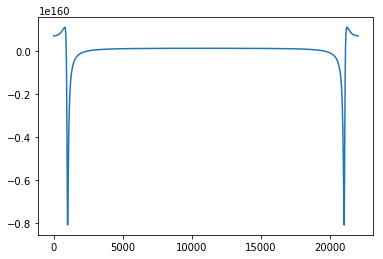

In [20]:
plt.plot(np.fft.fft(x6))

In [21]:
[1,2,3,4,5][5-3:]

[3, 4, 5]

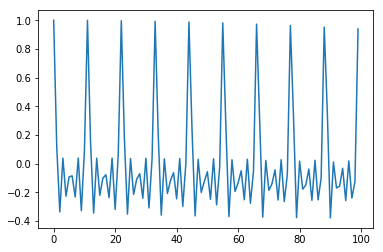

In [22]:
test_message = [True, False]

SAMPLES_PER_SYMBOL = 10000

sent_test_message = generic_encoder(test_message, SAMPLES_PER_SYMBOL, waveformer)

plt.plot(np.arange(0,100,1), sent_test_message[:100])

fd = open("test_message.txt", "w")
for fl in sent_test_message:
    fd.write(str(fl))
    fd.write(" ")
    
fd.close()

# Documents/JupyterNotebooks/PDCProject/PDC-Project

#python client.py --input_file=test_message.txt --output_file=result_test.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80


In [ ]:
result_message = []

with open("result_test.txt","r") as fr:  
    for cnt, line in enumerate(fr):
        result_message.append(float(line))

fr.close()

plt.plot(np.arange(0,100,1), result_message[:100])

#print(len(sent_test_message))
#print(len(result_message))

recieved_test_message = decoder_v3(result_message, SAMPLES_PER_SYMBOL, len(test_message))

print(recieved_test_message)